### وارد کردن کتابخانه ها

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

In [5]:
#وارد کردن دیتاست شکایات به محیط پایتون
Data = pd.read_csv("C:\\Users\\ShahinN\\Desktop\\Consumer_Complaints.csv", encoding='latin-1')
Data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/21/2017,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77075,Older American,NaN,Phone,03/21/2017,Closed with non-monetary relief,Yes,No,2397100
1,04/19/2017,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,NaN,NaN,"Security Credit Services, LLC",IL,60643,NaN,NaN,Web,04/20/2017,Closed with explanation,Yes,No,2441777
2,04/19/2017,Credit card,NaN,Other,NaN,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,62025,NaN,NaN,Referral,04/20/2017,Closed with explanation,Yes,No,2441830
3,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165
4,04/19/2017,Credit card,NaN,Credit determination,NaN,NaN,Company has responded to the consumer and the ...,U.S. BANCORP,LA,70571,NaN,NaN,Postal mail,04/21/2017,Closed with explanation,Yes,No,2441726


In [6]:
#تحلیل های آماری
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777959 entries, 0 to 777958
Data columns (total 18 columns):
Date received                   777959 non-null object
Product                         777959 non-null object
Sub-product                     542822 non-null object
Issue                           777959 non-null object
Sub-issue                       320986 non-null object
Consumer complaint narrative    157865 non-null object
Company public response         197884 non-null object
Company                         777959 non-null object
State                           772056 non-null object
ZIP code                        772001 non-null object
Tags                            109264 non-null object
Consumer consent provided?      288311 non-null object
Submitted via                   777959 non-null object
Date sent to company            777959 non-null object
Company response to consumer    777959 non-null object
Timely response?                777959 non-null object
Consumer 

In [10]:
# انتخاب سطرها و ستون های مورد نیاز
Data = Data[['Product', 'Consumer complaint narrative']]
Data = Data[pd.notnull(Data['Consumer complaint narrative'])]

In [11]:
Data.head()

,Product,Consumer complaint narrative
9,Mortgage,Started the refinance of home mortgage process...
35,Bank account or service,My wife and I visited the Chase Bank branch at...
39,Student loan,The service representative was harsh and not l...
46,Bank account or service,I have documentation that shows that US Bank w...
54,Credit reporting,Experian reporting of XXXX XXXX reflects a for...


In [36]:
# فاکتورسازی ویژگی محصول
Data['category_id'] = Data['Product'].factorize()[0]
Data.head()

,Product,Consumer complaint narrative,category_id
9,Mortgage,Started the refinance of home mortgage process...,0
35,Bank account or service,My wife and I visited the Chase Bank branch at...,1
39,Student loan,The service representative was harsh and not l...,2
46,Bank account or service,I have documentation that shows that US Bank w...,1
54,Credit reporting,Experian reporting of XXXX XXXX reflects a for...,3


In [16]:
# بررسی توزیع محصولاتی که مورد شکایت واقع شده اند
Data.groupby('Product')['Consumer complaint narrative'].count() #.mean() / .median()

Product
Bank account or service    14500
Consumer Loan               9029
Credit card                18276
Credit reporting           30319
Debt collection            38741
Money transfers             1437
Mortgage                   32000
Other financial service      272
Payday loan                 1695
Prepaid card                1404
Student loan               10176
Virtual currency              16
Name: Consumer complaint narrative, dtype: int64

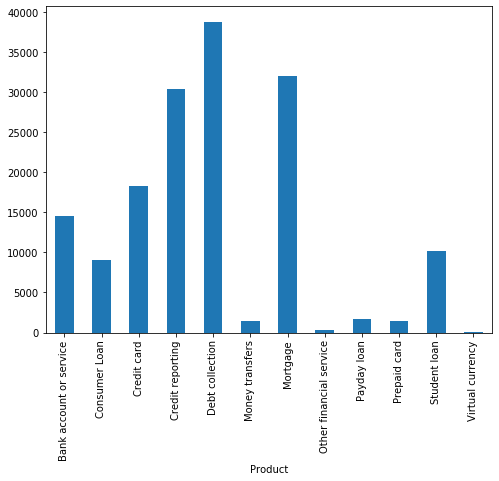

In [17]:
# رسم نمودار کد بالا
fig = plt.figure(figsize=(8,6))
Data.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [19]:
#بخش بندی دیتا
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['Consumer complaint narrative'], Data['Product'])

In [21]:
# مهندسی ویژگی با استفاده از بردار TF-IDF (با تولید حداکثر 5000 ویژگی)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['Consumer complaint narrative'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

In [22]:
# ساخت مدل یادگیری ماشین
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

C:\Users\ShahinN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ShahinN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [25]:
# ارزیابی مدل
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr',
                   n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
                 
                   
                   
                   

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
# چک کردن دقت یادگیری
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)

print ("Accuracy: ", accuracy)

Accuracy:  0.8527884055033319


In [28]:
# Classification report
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf),target_names=Data['Product'].unique()))


                         precision    recall  f1-score   support

               Mortgage       0.83      0.82      0.82      3671
Bank account or service       0.79      0.60      0.69      2239
           Student loan       0.81      0.82      0.81      4625
       Credit reporting       0.87      0.86      0.87      7618
            Credit card       0.82      0.89      0.85      9763
        Debt collection       0.78      0.54      0.64       361
          Consumer Loan       0.92      0.95      0.94      7896
Other financial service       0.00      0.00      0.00        55
        Money transfers       0.75      0.34      0.47       437
           Prepaid card       0.85      0.54      0.66       348
            Payday loan       0.92      0.87      0.89      2448
       Virtual currency       0.00      0.00      0.00         6

               accuracy                           0.85     39467
              macro avg       0.69      0.60      0.64     39467
           weighted avg

C:\Users\ShahinN\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
#confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))
conf_mat

array([[3001,   25,  288,   66,   92,   36,  128,    0,    1,   30,    4,
           0],
       [  57, 1349,  149,  139,  353,    0,  136,    0,   19,    0,   37,
           0],
       [ 196,   34, 3811,  203,  320,    6,   48,    0,    0,    4,    3,
           0],
       [  26,   55,  145, 6586,  670,    0,  103,    0,    0,    0,   33,
           0],
       [  60,  111,  186,  379, 8707,    1,  198,    0,   30,    0,   91,
           0],
       [ 111,    4,   14,    3,   23,  195,   11,    0,    0,    0,    0,
           0],
       [  61,   26,   34,  101,  121,    1, 7540,    0,    0,    0,   12,
           0],
       [  14,    1,    4,    6,   15,    6,    3,    0,    0,    0,    6,
           0],
       [  25,   67,    9,   14,  146,    1,   15,    0,  150,    0,   10,
           0],
       [  61,    1,   76,    5,   10,    5,    3,    0,    0,  187,    0,
           0],
       [   8,   24,   15,   45,  184,    0,   41,    0,    0,    0, 2131,
           0],
       [   4,    0,  

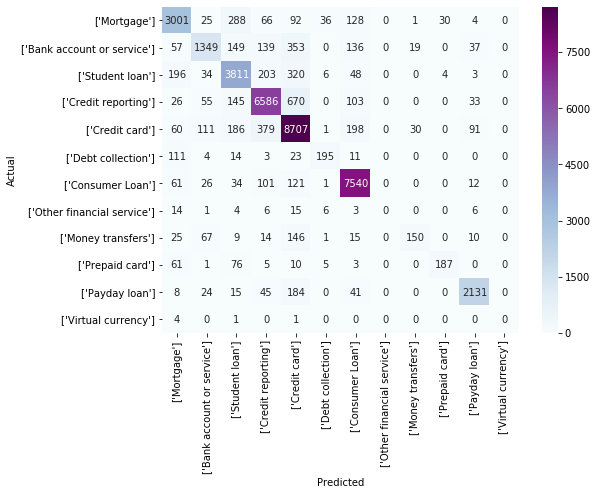

In [37]:
#مصور سازی CONFUSION MATRIX
category_id_df = Data[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            cmap="BuPu",
            xticklabels=category_id_df[['Product']].values,
            yticklabels=category_id_df[['Product']].values)


plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [42]:
# مثال پیش بینی
texts = ["how much I have to wait to transfer money? This is really bad"]
         
text_features = tfidf_vect.transform(texts)

predictions = model.predict(text_features)

print(texts)

print(" - Predicted as: '{}'".format(id_to_category[predictions[0]]))


['how much I have to wait to transfer money?']
 - Predicted as: 'Debt collection'
